# VGA Skeleton Reprojection

In this example, we reproject body skeletons on the VGA images.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

# For camera projection (with distortion)
import panutils

In [2]:
# Setup paths
data_path = '../'
seq_name = 'sampleData'

skel_json_path = data_path+seq_name+'/vgaPose3d_stage1/'
vga_img_path = data_path+seq_name+'/vgaImgs/'

In [3]:
# Load camera calibration parameters
with open(data_path+seq_name+'/calibration_{0}.json'.format(seq_name)) as cfile:
    calib = json.load(cfile)

# Cameras are identified by a tuple of (panel#,node#)
cameras = {(cam['panel'],cam['node']):cam for cam in calib['cameras']}

# Convert data into numpy arrays for convenience
for k,cam in cameras.iteritems():    
    cam['K'] = np.matrix(cam['K'])
    cam['distCoef'] = np.array(cam['distCoef'])[[0,1,4,3,2]]
    cam['R'] = np.matrix(cam['R'])
    cam['t'] = np.array(cam['t']).reshape((3,1))
    
# Select the first 10 cameras in a uniformly sampled order
cams = panutils.get_uniform_camera_order()[0:10]
sel_cameras = [cameras[cam].copy() for cam in cams]

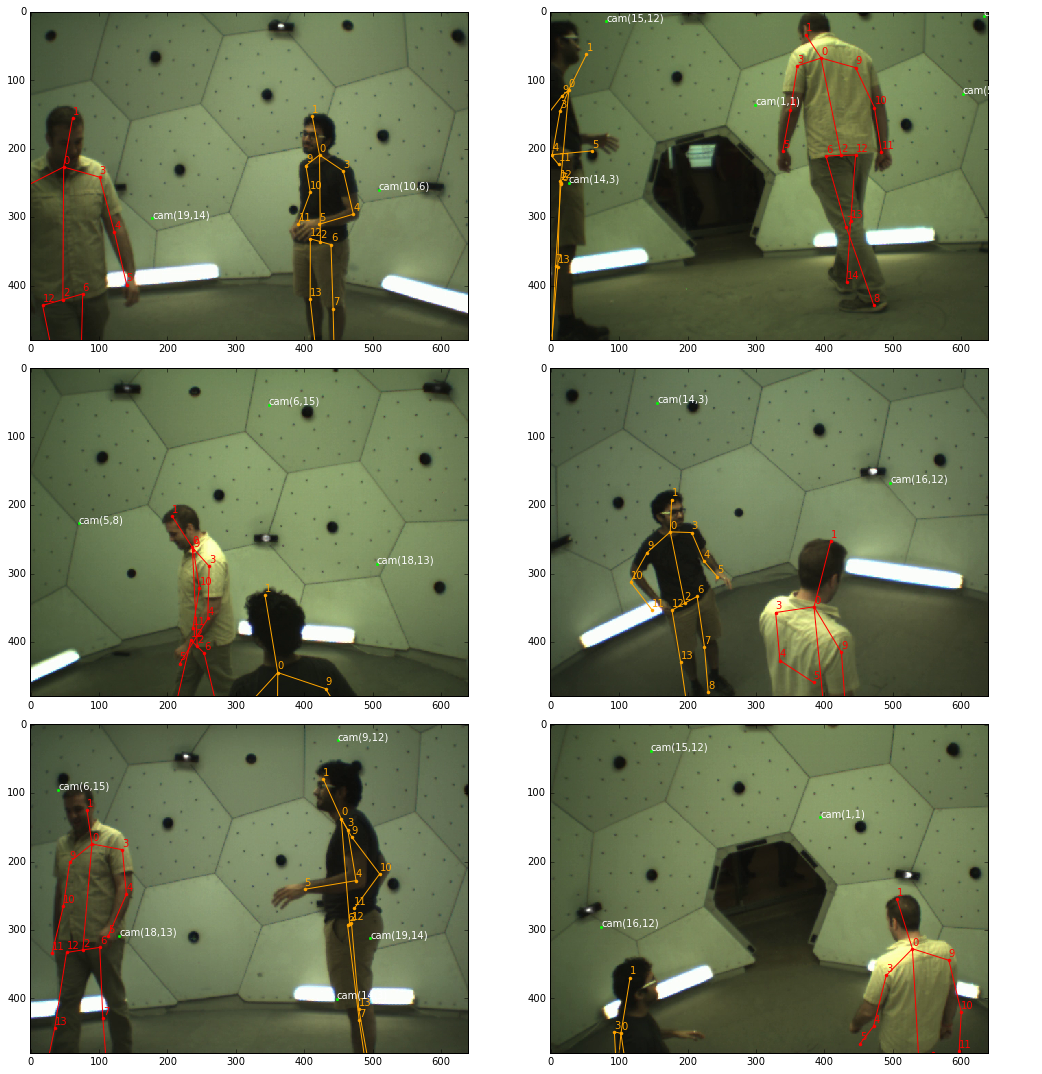

In [4]:
# Reproject skeletons onto the first 6 camera views

# Edges between joints in the skeleton
edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1
colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

# Frame
idx = 0 

plt.figure(figsize=(15,15))
for icam in xrange(6):
    # Select an HD camera
    cam = sel_cameras[icam]
    
    # Load the corresponding frame
    image_path = vga_img_path+'{0:02d}_{1:02d}/{0:02d}_{1:02d}_{2:08d}.png'.format(cam['panel'], cam['node'], idx)
    im = plt.imread(image_path)

    plt.subplot(3,2,icam+1)
    
    plt.imshow(im)
    currentAxis = plt.gca()
    currentAxis.set_autoscale_on(False)

        
    try:
        # Load the json file with this frame's skeletons
        skel_json_fname = skel_json_path+'body3DScene_{0:08d}.json'.format(idx)
        with open(skel_json_fname) as dfile:
            bframe = json.load(dfile)

        # Cycle through all detected bodies
        for ids in xrange(len(bframe['bodies'])):
            body = bframe['bodies'][ids]
            
            # There are 15 3D joints, stored as an array:
            # [x1,y1,z1,c1,x2,y2,z2,c2,...]
            # where c1 ... c15 are per-joint detection confidences
            skel = np.array(body['joints15']).reshape((-1,4)).transpose()

            # Project skeleton into view (this is like cv2.projectPoints)
            pt = panutils.projectPoints(skel[0:3,:],
                          cam['K'], cam['R'], cam['t'], 
                          cam['distCoef'])

            # Only points in front of the camera should be shown
            valid = np.logical_and(pt[2,:]>0, skel[3,:]>0.1)

            plt.plot(pt[0,valid], pt[1,valid], '.', color=colors[body['id']])
                                
            # Plot edges for each bone
            for edge in edges:
                if valid[edge[0]] or valid[edge[1]]:
                    plt.plot(pt[0,edge], pt[1,edge], color=colors[body['id']])
                    
            # Show the joint numbers
            for ip in xrange(pt.shape[1]):
                if pt[0,ip]>=0 and pt[0,ip]<im.shape[1] and pt[1,ip]>=0 and pt[1,ip]<im.shape[0]:
                    plt.text(pt[0,ip], pt[1,ip]-5, '{0}'.format(ip),color=colors[body['id']])
                    
    except IOError as e:
        print('Error reading {0}\n'.format(skel_json_fname)+e.strerror)
        
    # Also plot selected cameras with (panel,node) label
    for ca in sel_cameras:
        cc = (-ca['R'].transpose()*ca['t'])
        pt = panutils.projectPoints(cc,
                      cam['K'], cam['R'], cam['t'], 
                      cam['distCoef'])
        if pt[0]>=0 and pt[0]<im.shape[1] and pt[1]>=0 and pt[1]<im.shape[0]:
            plt.plot(pt[0], pt[1], '.', color=[0,1,0], markersize=5)
            plt.text(pt[0], pt[1], 'cam({0},{1})'.format(ca['panel'],ca['node']), color=[1,1,1])
        
plt.tight_layout()

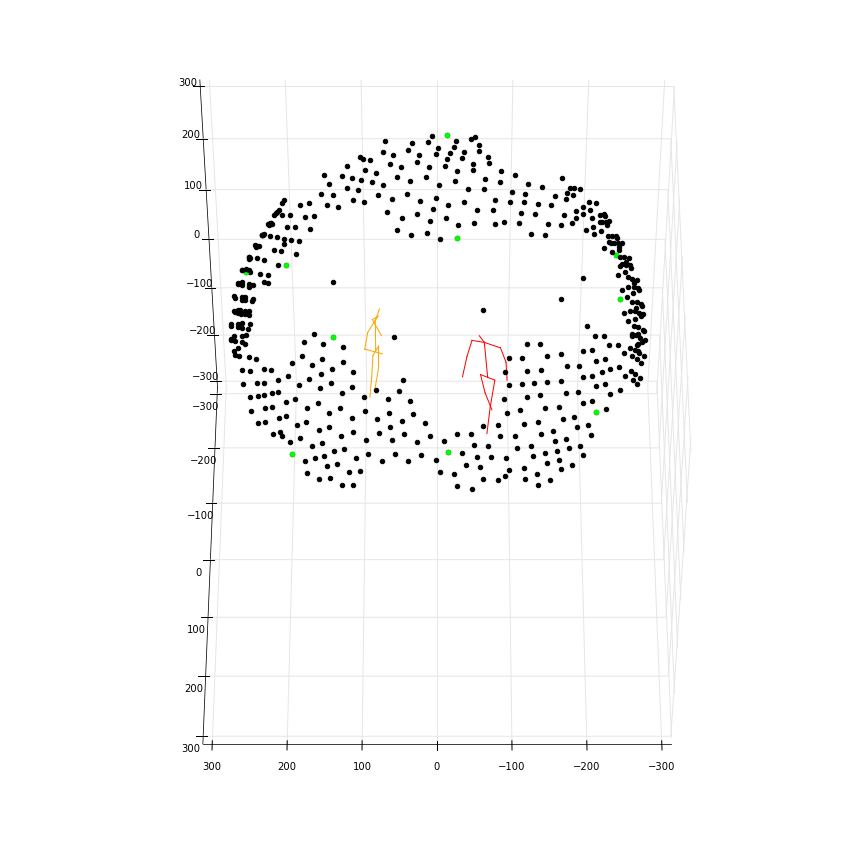

In [5]:
# Plot all cameras and skeletons in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(50,90)

# Draw all cameras in black
for k,cam in cameras.iteritems():
    cc = (-cam['R'].transpose()*cam['t'])
    ax.scatter(cc[0], cc[1], cc[2], '.', color=[0,0,0])

# Selected camera subset in green
for cam in sel_cameras:
    cc = (-cam['R'].transpose()*cam['t'])
    ax.scatter(cc[0], cc[1], cc[2], '.', color=[0,1,0])
    
# Bodies
for ids in xrange(len(bframe['bodies'])):
    body = bframe['bodies'][ids]
    skel = np.array(body['joints15']).reshape((-1,4)).transpose()

    for edge in edges:
        if valid[edge[0]] or valid[edge[1]]:
            ax.plot(skel[0,edge], skel[1,edge], skel[2,edge], color=colors[body['id']])

ax.set_aspect('equal')
ax.set_xlim3d([-300, 300])
ax.set_ylim3d([-300, 300])
ax.set_zlim3d([-300, 300])
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
